# Preprocess

This notebook preprocesses the downloaded data.

## Settings

In [64]:
folder = '../tmp/downloads' # stores downloads
dist_folder = '../tmp/dist' # stores outputs
data_sources_file = 'data.csv'
study_area_dataset = 'toronto' # bbox will be used as study area
force = False # whether to force processing
processed = {} # stores processed datasets

## Libraries

In [65]:
import pandas as pd
import geopandas as gpd
import numpy as np

from datetime import datetime, timedelta
from IPython.display import display, HTML
from pathlib import Path
from shapely.geometry import box, Point
from time import time

## Classes

In [66]:
# For timing processes and displaying processing messages
class Timer:
    
    def __init__(self, name, process_name=None, start_prefix=None, end_prefix=None):
        self.name = name
        self.process_name = process_name
        self.start_prefix = start_prefix if start_prefix else 'Loading' if process_name.startswith('already') else 'Processing'
        self.end_prefix = end_prefix if end_prefix else 'Loaded' if process_name.startswith('already') else 'Processed'
    
    def start(self):
        self.start = time()
        self.start_dt = datetime.now()
        print(f'{self.start_prefix} {self.name} - {self.process_name} ({self.start_dt})...')
    
    def end(self):
        self.end = time()
        self.end_dt = datetime.now()
        self.elapsed = str(timedelta(seconds=self.end - self.start))
        print(f'{self.end_prefix} {self.name} - {self.process_name} ({self.end_dt}) [Elapsed: {self.elapsed}]')

## Functions

In [67]:
# Formats human readable sizes in bytes
# https://stackoverflow.com/questions/1094841/get-human-readable-version-of-file-size
def format_size(num, suffix="B"):
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return f"{num:3.1f} {unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f} Yi{suffix}"

# Extracts file info for summary
def file_info(file):
    stats = Path(file).stat()
    modified = datetime.fromtimestamp(stats.st_mtime)
    created = datetime.fromtimestamp(stats.st_birthtime)
    size = format_size(stats.st_size)
    out = {'created': created, 'modified': modified, 'size': size}
    return out

# Get basic info on a pandas dataframe
def df_info(df, name):
    memory = format_size(df.memory_usage().sum())
    cols = len(df.columns)
    rows = len(df)
    geometry = str(pd.unique(df.geometry.geom_type)) if 'geometry' in df else None
    out = {
        'dataset': name,
        'columns': cols,
        'rows': rows,
        'memory_usage': memory,
        'geometry': geometry
    }
    return out

# Read csv, shp, or geojson file into pandas or geopandas
def read_data(file, sheet_name=None, *args, **kwargs):
    path = Path(file)
    ext = path.suffix if path.suffix != '.zip' else path.suffixes[0]
    ext = ext.lower()
    if ext == '.csv':
        out = pd.read_csv(file, *args, **kwargs)
    elif ext in ['.xlsx', '.xls']:
        out = pd.read_excel(file, sheet_name=sheet_name, *args, **kwargs)
    elif ext in ['.geojson', '.shp']:
        out = gpd.read_file(file, *args, **kwargs)
    else:
        raise ValueError('File format not supported')
    return out

# Read data sources into pandas or geopandas datasets
def read_datasets(sources, folder=folder, *args, **kwargs):
    out = {}
    for row in sources.itertuples():
        
        # Define vars
        dataset = Path(row.file).with_suffix('').stem
        file = f'{folder}/{row.file}'
        
        # Start loading
        timer = Timer(file, 'read dataset', 'Loading', 'Loaded')
        timer.start()
        out[dataset] = read_data(file, *args, **kwargs)
        
        # End loading
        timer.end()
    return out

## Data

Read datasets from downloaded data files.

In [68]:
data_sources = read_data(data_sources_file)

### Non-Excel Spreadsheets

Read non-excel spreadsheet datasets:

In [69]:
non_excel = data_sources[~data_sources['file'].str.endswith('.xlsx')]
datasets = read_datasets(non_excel)

Loading ../tmp/downloads/toronto.geojson - read dataset (2022-02-11 23:23:07.959064)...
Loaded ../tmp/downloads/toronto.geojson - read dataset (2022-02-11 23:23:08.099661) [Elapsed: 0:00:00.140596]
Loading ../tmp/downloads/centrelines.geojson.zip - read dataset (2022-02-11 23:23:08.099875)...
Loaded ../tmp/downloads/centrelines.geojson.zip - read dataset (2022-02-11 23:23:16.574463) [Elapsed: 0:00:08.474586]
Loading ../tmp/downloads/collisions.geojson - read dataset (2022-02-11 23:23:16.574628)...
Loaded ../tmp/downloads/collisions.geojson - read dataset (2022-02-11 23:23:46.357968) [Elapsed: 0:00:29.783339]
Loading ../tmp/downloads/traffic.csv.zip - read dataset (2022-02-11 23:23:46.358135)...
Loaded ../tmp/downloads/traffic.csv.zip - read dataset (2022-02-11 23:23:47.361538) [Elapsed: 0:00:01.003401]
Loading ../tmp/downloads/autospeed_enforcement.geojson - read dataset (2022-02-11 23:23:47.361707)...
Loaded ../tmp/downloads/autospeed_enforcement.geojson - read dataset (2022-02-11 23:

### Excel Spreadsheets

Combine/remove sheets in excel spreadsheets:

#### education

In [70]:
# Read selected sheets
name = 'education'
datasets[name] = read_data(f'{folder}/{name}.xlsx', sheet_name=[1,2])

# Rename cols for ref year
datasets[name][1].columns = [
    f'{c} 2008' if c != 'Neighbourhood Id' else c for c in datasets[name][1].columns
]
datasets[name][2].columns = [
    f'{c} 2011' if c != 'Neighbourhood Id' else c for c in datasets[name][2].columns
]

# Join sheets together
datasets[name] = pd.merge(
    datasets[name][1],
    datasets[name][2],
    on='Neighbourhood Id',
    how='left'
)

datasets['education']

,Neighbourhood 2008,Neighbourhood Id,Catholic School Graduation 2008,Catholic School Literacy 2008,Catholic University Applicants 2008,Early Development Instrument 2008,Library Activity 2008,Library Open Hours 2008,Library Program Attendance 2008,Library Programs 2008,Library Space 2008,Neighbourhood 2011,Early Development Instrument 2011
0,West Humber-Clairville,1,0.810055,68.518516,33.110366,50,1,4,2,3,2,West Humber-Clairville,100
1,Mount Olive-Silverstone-Jamestown,2,0.792899,59.200000,19.122257,50,5,8,7,6,6,Mount Olive-Silverstone-Jamestown,1
2,Thistletown-Beaumond Heights,3,0.730000,68.888885,33.116882,100,5,9,6,6,6,Thistletown-Beaumond Heights,50
3,Rexdale-Kipling,4,0.864197,74.074073,32.330825,50,5,9,6,6,6,Rexdale-Kipling,100
4,Elms-Old Rexdale,5,0.653333,59.200000,28.695652,50,1,4,1,2,2,Elms-Old Rexdale,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,West Hill,136,0.865030,80.213905,38.425926,50,2,4,2,2,3,West Hill,1
136,Woburn,137,0.829999,78.787879,37.049179,50,5,7,6,6,5,Woburn,100
137,Eglinton East,138,0.833333,72.727272,42.424243,100,2,4,2,3,2,Eglinton East,50
138,Scarborough Village,139,0.788461,76.190475,32.258064,50,4,7,5,6,5,Scarborough Village,50


#### environment

In [71]:
# Read selected sheets
name = 'environment'
datasets[name] = read_data(f'{folder}/{name}.xlsx', sheet_name=[1,2])

# Rename cols for ref year
datasets[name][1].columns = [
    f'{c} 2008' if c != 'Neighbourhood Id' else c for c in datasets[name][1].columns
]
datasets[name][2].columns = [
    f'{c} 2011' if c != 'Neighbourhood Id' else c for c in datasets[name][2].columns
]

# Join sheets together
datasets[name] = pd.merge(
    datasets[name][1],
    datasets[name][2],
    on='Neighbourhood Id',
    how='left'
)

datasets['environment']

,Neighbourhood 2008,Neighbourhood Id,City Green Retrofits 2008,Green Rebate Programs 2008,Green Spaces 2008,Polluting Facilities 2008,Tree Cover 2008,Neighbourhood 2011,Green Rebate Programs 2011,Green Spaces 2011,Pollutant Carcinogenic TEP Score 2011,Pollutant Non-Carcinogenic TEP Score 2011,Pollutants Released to Air 2011,Tree Cover 2011
0,West Humber-Clairville,1,5,339,2.09802,81,2.895861e+06,West Humber-Clairville,428,2.078836,5737.87,18658529.73,1585690,2.895861e+06
1,Mount Olive-Silverstone-Jamestown,2,7,152,1.03964,0,1.303945e+06,Mount Olive-Silverstone-Jamestown,250,1.048870,29.76,2015.00,31,1.303945e+06
2,Thistletown-Beaumond Heights,3,0,110,0.93849,0,1.499130e+06,Thistletown-Beaumond Heights,118,0.939108,0.00,0.00,0,1.499130e+06
3,Rexdale-Kipling,4,1,103,0.24065,0,7.563823e+05,Rexdale-Kipling,121,0.240663,0.00,37632.00,35920,7.563823e+05
4,Elms-Old Rexdale,5,1,60,0.70749,1,9.975108e+05,Elms-Old Rexdale,73,0.730090,0.00,309.00,309,9.975108e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,West Hill,136,2,271,1.96760,10,3.403338e+06,West Hill,338,1.993607,104759.13,54076528.30,371626,3.403338e+06
136,Woburn,137,3,512,1.28579,11,2.746208e+06,Woburn,600,1.354012,0.00,17463.80,2357,2.746208e+06
137,Eglinton East,138,0,173,0.23025,3,6.563212e+05,Eglinton East,209,0.233049,27469.60,901516.80,4410,6.563212e+05
138,Scarborough Village,139,1,100,0.28573,0,1.127497e+06,Scarborough Village,115,0.286328,0.00,0.00,0,1.127497e+06


#### demographics

In [72]:
# Read selected sheets
name = 'demographics'
datasets[name] = read_data(f'{folder}/{name}.xlsx', sheet_name=[1,2])

# Rename id cols
datasets[name][1] = datasets[name][1].rename(columns={
    'HoodID': 'Neighbourhood Id'
})
datasets[name][2] = datasets[name][2].rename(columns={
    'NeighbourhoodID': 'Neighbourhood Id'
})

# Rename cols for ref year
datasets[name][1].columns = [
    f'{c} 2008' if c != 'Neighbourhood Id' else c for c in datasets[name][1].columns
]
datasets[name][2].columns = [
    f'{c} 2016' if c != 'Neighbourhood Id' else c for c in datasets[name][2].columns
]

# Join sheets together
datasets[name] = pd.merge(
    datasets[name][1],
    datasets[name][2],
    on='Neighbourhood Id',
    how='left'
)

datasets['demographics']

,Neighbourhood Id,Neighbourhood 2008,Pop2016 2008,Pop2011 2008,PopChg11t16 2008,Neighbourhood 2016,0 to 04 years 2016,0 to 14 years 2016,05 to 09 years 2016,10 to 14 years 2016,...,65 to 69 years 2016,65 years and over 2016,70 to 74 years 2016,75 to 79 years 2016,80 to 84 years 2016,85 to 89 years 2016,85 years and over 2016,90 to 94 years 2016,95 to 99 years 2016,Total Population - All Age Groups - 100% data 2016
0,1,West Humber-Clairville,33312,34100,-0.023109,West Humber-Clairville,1540.0,5060.0,1720.0,1790.0,...,1595.0,4980.0,1185.0,885.0,700.0,400.0,615.0,160.0,50.0,33320.0
1,2,Mount Olive-Silverstone-Jamestown,32954,32788,0.005063,Mount Olive-Silverstone-Jamestown,2190.0,7090.0,2500.0,2415.0,...,1285.0,3560.0,885.0,630.0,465.0,225.0,300.0,70.0,10.0,32950.0
2,3,Thistletown-Beaumond Heights,10360,10138,0.021898,Thistletown-Beaumond Heights,540.0,1730.0,600.0,595.0,...,490.0,1880.0,375.0,335.0,320.0,225.0,350.0,100.0,20.0,10360.0
3,4,Rexdale-Kipling,10529,10488,0.003909,Rexdale-Kipling,560.0,1640.0,515.0,565.0,...,520.0,1730.0,350.0,295.0,270.0,205.0,300.0,85.0,15.0,10530.0
4,5,Elms-Old Rexdale,9456,9550,-0.009843,Elms-Old Rexdale,540.0,1805.0,605.0,660.0,...,415.0,1275.0,305.0,235.0,180.0,105.0,145.0,40.0,5.0,9460.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,136,West Hill,27392,26547,0.031830,West Hill,1425.0,4635.0,1590.0,1630.0,...,1350.0,4240.0,975.0,775.0,520.0,365.0,625.0,210.0,60.0,27390.0
136,137,Woburn,53485,53350,0.002530,Woburn,3140.0,9625.0,3365.0,3125.0,...,2220.0,8010.0,1810.0,1550.0,1330.0,740.0,1130.0,305.0,60.0,53490.0
137,138,Eglinton East,22776,22829,-0.002322,Eglinton East,1315.0,4180.0,1480.0,1395.0,...,1015.0,3505.0,815.0,625.0,480.0,345.0,560.0,170.0,45.0,22775.0
138,139,Scarborough Village,16724,16609,0.006924,Scarborough Village,1055.0,3365.0,1200.0,1100.0,...,675.0,2225.0,455.0,365.0,300.0,245.0,430.0,135.0,25.0,16730.0


#### housing

In [73]:
# Read selected sheets
name = 'housing'
datasets[name] = read_data(f'{folder}/{name}.xlsx', sheet_name=[1,2])

# Rename cols for ref year
datasets[name][1].columns = [
    f'{c} 2008' if c != 'Neighbourhood Id' else c for c in datasets[name][1].columns
]
datasets[name][2].columns = [
    f'{c} 2011' if c != 'Neighbourhood Id' else c for c in datasets[name][2].columns
]

# Join sheets together
datasets[name] = pd.merge(
    datasets[name][1],
    datasets[name][2],
    on='Neighbourhood Id',
    how='left'
)

datasets['housing']

,Neighbourhood 2008,Neighbourhood Id,Households Assisted 2008,Rent Bank Applicants 2008,Social Housing Turnover 2008,Social Housing Units 2008,Social Housing Waiting List 2008,Neighbourhood 2011,Home Prices 2011,Mid-Century Highrise Households 2011,Mid-Century Highrise Population 2011,Percent Mid-Century Highrise Households 2011,Percent Mid-Century Highrise Population 2011,Rent Bank Applicants 2011,Social Housing Turnover 2011,Social Housing Units 2011,Social Housing Waiting List 2011
0,West Humber-Clairville,1,3,38,1.214285,960,445,West Humber-Clairville,317508,690,1810,6.8,5.3,38,0.312500,952,557
1,Mount Olive-Silverstone-Jamestown,2,1,62,8.363636,1138,914,Mount Olive-Silverstone-Jamestown,251119,4110,13395,42.9,40.9,41,7.000000,1146,1049
2,Thistletown-Beaumond Heights,3,0,14,0.000000,447,179,Thistletown-Beaumond Heights,414216,430,1260,13.4,12.4,7,1.333333,447,270
3,Rexdale-Kipling,4,0,25,0.000000,432,176,Rexdale-Kipling,392271,600,1050,15.2,10.0,19,4.200000,432,186
4,Elms-Old Rexdale,5,0,14,9.399999,571,191,Elms-Old Rexdale,233832,870,2305,27.3,24.1,14,1.000000,463,239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,West Hill,136,5,30,0.000000,2089,658,West Hill,308229,3010,5880,31.1,22.1,22,8.400000,2089,725
136,Woburn,137,12,42,6.000000,2594,1144,Woburn,316584,5090,14870,27.8,27.9,26,4.911765,2660,1306
137,Eglinton East,138,5,31,4.666666,865,600,Eglinton East,274020,3935,10105,48.8,44.3,33,2.588235,865,688
138,Scarborough Village,139,0,30,1.100000,922,565,Scarborough Village,356096,2905,7860,49.2,47.3,22,4.400000,922,683


#### economics

In [74]:
# Read selected sheets
name = 'economics'
datasets[name] = read_data(f'{folder}/{name}.xlsx', sheet_name=[1,2], skiprows=1)

# Rename cols for ref year
datasets[name][1].columns = [
    f'{c} 2008' if c != 'Neighbourhood Id' else c for c in datasets[name][1].columns
]
datasets[name][2].columns = [
    f'{c} 2011' if c != 'Neighbourhood Id' else c for c in datasets[name][2].columns
]

# Join sheets together
datasets[name] = pd.merge(
    datasets[name][1],
    datasets[name][2],
    on='Neighbourhood Id',
    how='left'
)

datasets['economics']

,Neighbourhood 2008,Neighbourhood Id,Access to Child Care 2008,Business Licensing 2008,Businesses 2008,Child Care Spaces 2008,Inequality (Gini coeff.) 2008,Local Employment 2008,Social Assistance Recipients 2008,Neighbourhood 2011,Businesses 2011,Child Care Spaces 2011,Debt Risk Score 2011,Home Prices 2011,Local Employment 2011,Social Assistance Recipients 2011
0,West Humber-Clairville,1,0.383582,695,2550,180.00000,0.359380,63385,2702.0,West Humber-Clairville,2463,195,719,317508,58271,2912
1,Mount Olive-Silverstone-Jamestown,2,0.245736,106,273,45.00000,0.420150,3346,6406.0,Mount Olive-Silverstone-Jamestown,271,60,687,251119,3244,6561
2,Thistletown-Beaumond Heights,3,0.325000,116,236,25.00000,0.382010,1350,1082.0,Thistletown-Beaumond Heights,217,25,718,414216,1311,1276
3,Rexdale-Kipling,4,0.240000,49,155,60.00000,0.388429,1190,1231.0,Rexdale-Kipling,144,75,721,392271,1178,1323
4,Elms-Old Rexdale,5,0.321622,31,70,60.00000,0.388130,831,1759.0,Elms-Old Rexdale,67,60,692,233832,903,1683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,West Hill,136,0.490647,225,439,134.00000,0.435829,4551,4448.0,West Hill,424,153,706,308229,4500,4974
136,Woburn,137,0.214933,333,1020,210.00000,0.414480,14374,6647.0,Woburn,1073,214,723,316584,16190,6747
137,Eglinton East,138,0.268571,130,313,153.00000,0.399830,2440,4405.0,Eglinton East,296,143,705,274020,2351,4171
138,Scarborough Village,139,0.350667,127,220,220.00000,0.432119,1926,3981.0,Scarborough Village,228,217,699,356096,1851,4133


#### civics

In [75]:
# Read selected sheets
name = 'civics'
datasets[name] = read_data(f'{folder}/{name}.xlsx', sheet_name=[1,2], skiprows=1)

# Rename cols for ref year
datasets[name][1].columns = [
    f'{c} 2008' if c != 'Neighbourhood Id' else c for c in datasets[name][1].columns
]
datasets[name][2].columns = [
    f'{c} 2011' if c != 'Neighbourhood Id' else c for c in datasets[name][2].columns
]

# Join sheets together
datasets[name] = pd.merge(
    datasets[name][1],
    datasets[name][2],
    on='Neighbourhood Id',
    how='left'
)

datasets['civics']

,Neighbourhood 2008,Neighbourhood Id,City Beautification 2008,City Grants Funding $ 2008,Diversity Index 2008,Voter Turnout 2008,Watermain Breaks 2008,Neighbourhood 2011,City Grants Funding $ 2011,Neighbourhood Equity Score 2011,Salvation Army Donors 2011,Walk Score 2011,Watermain Breaks 2011
0,West Humber-Clairville,1,191,520390.000,4.769540,34.7571,30,West Humber-Clairville,123283.0,45.78,640,57,30
1,Mount Olive-Silverstone-Jamestown,2,55,10040.000,4.969163,28.1441,8,Mount Olive-Silverstone-Jamestown,238172.0,29.29,222,61,8
2,Thistletown-Beaumond Heights,3,25,158658.000,5.106365,40.5373,9,Thistletown-Beaumond Heights,7296.0,39.78,218,54,9
3,Rexdale-Kipling,4,19,49210.000,5.208610,39.7091,5,Rexdale-Kipling,35100.0,43.76,336,58,5
4,Elms-Old Rexdale,5,17,42870.000,5.502152,34.0128,10,Elms-Old Rexdale,0.0,29.54,152,48,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,West Hill,136,79,297563.000,5.301753,32.5398,8,West Hill,55370.0,37.25,765,66,8
136,Woburn,137,105,371010.000,5.021696,37.2474,22,Woburn,144255.0,39.01,1429,66,22
137,Eglinton East,138,46,94295.000,5.184124,35.3157,5,Eglinton East,5800.0,36.28,396,62,5
138,Scarborough Village,139,32,253268.125,5.178616,32.9390,6,Scarborough Village,3200.0,33.94,410,70,6


#### health

In [76]:
# Read selected sheets
name = 'health'
datasets[name] = read_data(f'{folder}/{name}.xlsx', sheet_name=[1,2], skiprows=1)

# Rename cols for ref year
datasets[name][1].columns = [
    f'{c} 2008' if c != 'Neighbourhood Id' else c for c in datasets[name][1].columns
]
datasets[name][2].columns = [
    f'{c} 2011' if c != 'Neighbourhood Id' else c for c in datasets[name][2].columns
]

# Join sheets together
datasets[name] = pd.merge(
    datasets[name][1],
    datasets[name][2],
    on='Neighbourhood Id',
    how='left'
)

datasets['health']

,Neighbourhood 2008,Neighbourhood Id,Breast Cancer Screenings 2008,Cervical Cancer Screenings 2008,Colorectal Cancer Screenings 2008,Community Food Programs 2008,Diabetes Prevalence 2008,DineSafe Inspections 2008,Female Fertility 2008,Health Providers 2008,...,Student Nutrition 2008,Teen Pregnancy 2008,Neighbourhood 2011,Breast Cancer Screenings 2011,Cervical Cancer Screenings 2011,DineSafe Inspections 2011,Female Fertility 2011,Health Providers 2011,Premature Mortality 2011,Student Nutrition 2011
0,West Humber-Clairville,1,52.3,60.4,38.7,2,14.0,45,60.286693,94,...,1190,30.917874,West Humber-Clairville,57.02,60.52,10,59.923279,101,223.8,1105
1,Mount Olive-Silverstone-Jamestown,2,47.8,54.6,36.8,3,14.9,2,71.103462,39,...,5026,37.106918,Mount Olive-Silverstone-Jamestown,50.14,55.75,2,64.410021,44,242.6,5132
2,Thistletown-Beaumond Heights,3,54.8,60.1,38.2,2,12.0,0,60.681976,10,...,950,38.418079,Thistletown-Beaumond Heights,55.22,61.15,4,57.480863,14,226.1,950
3,Rexdale-Kipling,4,56.0,62.6,37.2,2,11.9,0,52.042160,6,...,125,33.879781,Rexdale-Kipling,54.28,64.69,0,45.586298,6,282.7,180
4,Elms-Old Rexdale,5,54.7,61.1,35.6,1,12.7,0,65.449630,1,...,1975,39.344262,Elms-Old Rexdale,55.15,61.54,1,61.392833,1,163.6,2030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,West Hill,136,55.0,63.4,38.9,5,13.3,2,48.014076,28,...,1540,55.121043,West Hill,58.00,61.50,1,48.366013,33,248.9,1725
136,Woburn,137,55.0,60.4,39.4,5,13.6,33,56.722587,90,...,6172,40.305011,Woburn,56.83,60.67,6,55.628495,93,187.8,5690
137,Eglinton East,138,55.0,60.3,36.2,0,14.6,2,55.619995,22,...,935,36.888889,Eglinton East,56.70,59.10,8,53.686827,19,214.7,1005
138,Scarborough Village,139,53.0,60.6,35.7,4,14.6,3,48.911224,25,...,2047,38.364780,Scarborough Village,54.67,59.76,4,55.695142,24,239.2,2157


### Study Area

Get the dataset for the study area:

<AxesSubplot:>

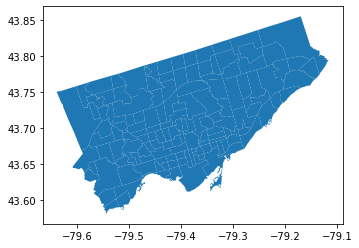

In [77]:
study_area = datasets[study_area_dataset]
study_area.plot()

### Neighbourhoods

Format neighbourhoods for spatial binning and save in clean data:

In [78]:
# Rename neighbourhood id
nbhoods = study_area
nbhoods = nbhoods.rename(columns={
    'AREA_SHORT_CODE': 'Neighbourhood Id'
})

# Format neighbourhood ids to be ints
nbhoods['Neighbourhood Id'] = nbhoods['Neighbourhood Id'].astype(int)

# Keep only id and geometry
nbhoods = nbhoods[['Neighbourhood Id', 'geometry']]

## Run

Create folders to store processed data:

In [79]:
Path(dist_folder).mkdir(parents=True, exist_ok=True)
Path(f'{dist_folder}/clean-datasets').mkdir(parents=True, exist_ok=True)

The following datasets will be preprocessed:

In [80]:
info = pd.DataFrame([df_info(df, name) for name, df in datasets.items() if name != study_area_dataset])
info

,dataset,columns,rows,memory_usage,geometry
0,centrelines,41,70828,22.2 MiB,['LineString']
1,collisions,18,499538,68.6 MiB,['Point']
2,traffic,59,226110,101.8 MiB,None
3,autospeed_enforcement,6,100,4.8 KiB,['Point']
4,watch_your_speed,14,783,85.8 KiB,['Point']
5,red_light_cams,32,200,50.1 KiB,['Point']
6,police,6,32,1.6 KiB,['Point']
7,ambulance,30,46,10.9 KiB,['Point']
8,fire_hydrants,6,41936,1.9 MiB,['Point']
9,fire_stations,30,92,21.7 KiB,['Point']


Track processing time for all datasets and procedures:

In [81]:
gtimer = Timer('all datasets', 'preprocessing')
gtimer.start()

Processing all datasets - preprocessing (2022-02-11 23:23:52.380268)...


### Geodata Conversion

Convert data without geometries to geospatial data.

#### traffic

Convert longitude/latitude to point geometries:

In [82]:
# Start processing
timer = Timer('traffic', 'geoconversion')
timer.start()

# Convert coords to points
df = datasets['traffic']
datasets['traffic'] = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lng, df.lat),
    crs='EPSG:4326'
)

# End processing
timer.end()

Processing traffic - geoconversion (2022-02-11 23:23:52.383512)...
Processed traffic - geoconversion (2022-02-11 23:23:52.421204) [Elapsed: 0:00:00.037691]


In [83]:
datasets['traffic'].geometry

0         POINT (-79.39326 43.70528)
1         POINT (-79.39326 43.70528)
2         POINT (-79.39326 43.70528)
3         POINT (-79.39326 43.70528)
4         POINT (-79.39326 43.70528)
                     ...            
226105    POINT (-79.42188 43.65904)
226106    POINT (-79.42188 43.65904)
226107    POINT (-79.42188 43.65904)
226108    POINT (-79.42188 43.65904)
226109    POINT (-79.42188 43.65904)
Name: geometry, Length: 226110, dtype: geometry

#### Wellbeing Toronto

Join wellbeing toronto datasets to neighbourhood polygons:

In [84]:
wellbeing = [
    'education',
    'environment',
    'demographics',
    'housing',
    'economics',
    'civics',
    'health'
]

# Join to polygons based on nbhood id
for name in wellbeing:
    
    # Start processing
    timer = Timer(name, 'geoconversion')
    timer.start()
    
    # Join by nbhood id
    datasets[name] = pd.merge(
        nbhoods,
        datasets[name],
        on='Neighbourhood Id',
        how='left'
    )

    # End processing
    timer.end()

Processing education - geoconversion (2022-02-11 23:23:52.430034)...
Processed education - geoconversion (2022-02-11 23:23:52.432638) [Elapsed: 0:00:00.002603]
Processing environment - geoconversion (2022-02-11 23:23:52.432672)...
Processed environment - geoconversion (2022-02-11 23:23:52.434067) [Elapsed: 0:00:00.001394]
Processing demographics - geoconversion (2022-02-11 23:23:52.434183)...
Processed demographics - geoconversion (2022-02-11 23:23:52.435691) [Elapsed: 0:00:00.001507]
Processing housing - geoconversion (2022-02-11 23:23:52.435716)...
Processed housing - geoconversion (2022-02-11 23:23:52.437035) [Elapsed: 0:00:00.001319]
Processing economics - geoconversion (2022-02-11 23:23:52.437059)...
Processed economics - geoconversion (2022-02-11 23:23:52.438402) [Elapsed: 0:00:00.001342]
Processing civics - geoconversion (2022-02-11 23:23:52.438483)...
Processed civics - geoconversion (2022-02-11 23:23:52.439839) [Elapsed: 0:00:00.001356]
Processing health - geoconversion (2022-

<AxesSubplot:>

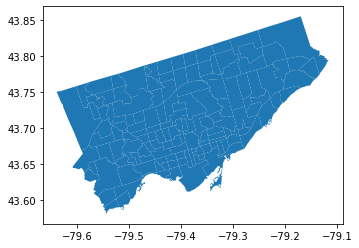

In [85]:
datasets['health'].plot()

### Extract Bounding Box

Get the bounding box from the `toronto` dataset:

In [86]:
# Start processing
timer = Timer('bbox', 'bbox extraction')
timer.start()

# Extract bbox
bbox = gpd.GeoSeries(box(*study_area.total_bounds), crs='EPSG:4326')

# End processing
timer.end()

Processing bbox - bbox extraction (2022-02-11 23:23:52.533425)...
Processed bbox - bbox extraction (2022-02-11 23:23:52.535129) [Elapsed: 0:00:00.001704]


<AxesSubplot:>

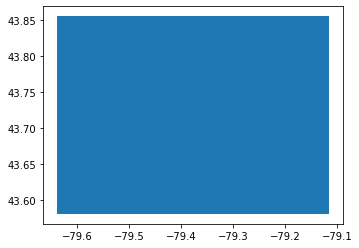

In [87]:
bbox.plot()

### Normalize Projections

Ensure that all datasets have the same projections as the study area `bbox`:

In [88]:
# Normalize projections
crs = bbox.estimate_utm_crs()
bbox = bbox.to_crs(crs)
for name, df in datasets.items():
    
    # Start processing
    timer = Timer(name, 'reprojection')
    timer.start()
    datasets[name] = df.to_crs(crs)
    
    # End processing
    timer.end()

Processing toronto - reprojection (2022-02-11 23:23:52.770746)...
Processed toronto - reprojection (2022-02-11 23:23:52.805754) [Elapsed: 0:00:00.035009]
Processing centrelines - reprojection (2022-02-11 23:23:52.805814)...
Processed centrelines - reprojection (2022-02-11 23:23:53.215087) [Elapsed: 0:00:00.409271]
Processing collisions - reprojection (2022-02-11 23:23:53.241122)...
Processed collisions - reprojection (2022-02-11 23:23:53.828747) [Elapsed: 0:00:00.587624]
Processing traffic - reprojection (2022-02-11 23:23:53.969887)...
Processed traffic - reprojection (2022-02-11 23:23:54.245656) [Elapsed: 0:00:00.275769]
Processing autospeed_enforcement - reprojection (2022-02-11 23:23:54.248434)...
Processed autospeed_enforcement - reprojection (2022-02-11 23:23:54.251205) [Elapsed: 0:00:00.002771]
Processing watch_your_speed - reprojection (2022-02-11 23:23:54.251405)...
Processed watch_your_speed - reprojection (2022-02-11 23:23:54.254274) [Elapsed: 0:00:00.002869]
Processing red_l

Reproject neighbourhood polygons:

In [89]:
nbhoods = nbhoods.to_crs(crs)

Check crs:

In [90]:
crs

<Derived Projected CRS: EPSG:32617>
Name: WGS 84 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°W and 78°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Ecuador - north of equator. Canada - Nunavut; Ontario; Quebec. Cayman Islands. Colombia. Costa Rica. Cuba. Jamaica. Nicaragua. Panama. United States (USA).
- bounds: (-84.0, 0.0, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Display projected crs:

In [91]:
proj = pd.DataFrame(
    [{'dataset': name, 'projected_crs': str(df.crs)} for name, df in datasets.items() if name != study_area_dataset]
)
proj

,dataset,projected_crs
0,centrelines,epsg:32617
1,collisions,epsg:32617
2,traffic,epsg:32617
3,autospeed_enforcement,epsg:32617
4,watch_your_speed,epsg:32617
5,red_light_cams,epsg:32617
6,police,epsg:32617
7,ambulance,epsg:32617
8,fire_hydrants,epsg:32617
9,fire_stations,epsg:32617


### Clip Data

Clip data to study area bounds:

In [92]:
# Clip datasets to study area bbox
for name, df in datasets.items():
        
    # Start processing
    timer = Timer(name, 'clip')
    timer.start()

    # Clip data to study area
    datasets[name] = df.clip(bbox, keep_geom_type=True)

    # End processing
    timer.end()

Processing toronto - clip (2022-02-11 23:23:54.734498)...
Processed toronto - clip (2022-02-11 23:23:54.752455) [Elapsed: 0:00:00.017956]
Processing centrelines - clip (2022-02-11 23:23:54.752608)...
Processed centrelines - clip (2022-02-11 23:23:55.659841) [Elapsed: 0:00:00.907231]
Processing collisions - clip (2022-02-11 23:23:55.685081)...
Processed collisions - clip (2022-02-11 23:23:56.246991) [Elapsed: 0:00:00.561909]
Processing traffic - clip (2022-02-11 23:23:56.395129)...
Processed traffic - clip (2022-02-11 23:23:56.638357) [Elapsed: 0:00:00.243232]
Processing autospeed_enforcement - clip (2022-02-11 23:23:56.643232)...
Processed autospeed_enforcement - clip (2022-02-11 23:23:56.645783) [Elapsed: 0:00:00.002552]
Processing watch_your_speed - clip (2022-02-11 23:23:56.645824)...
Processed watch_your_speed - clip (2022-02-11 23:23:56.648884) [Elapsed: 0:00:00.003059]
Processing red_light_cams - clip (2022-02-11 23:23:56.648951)...
Processed red_light_cams - clip (2022-02-11 23:

In [93]:
# Calculate info for clipped datasets
info_clip = pd.DataFrame([df_info(df, name) for name, df in datasets.items() if name != study_area_dataset])

# Calculate difference in cols and rows from clip
info_diff = info[['columns', 'rows']] - info_clip[['columns', 'rows']]

# Add original datasets info
info_diff = pd.concat([info[['columns', 'rows', 'memory_usage', 'geometry']], info_diff], axis=1)
info_diff.columns = ['columns_orig', 'rows_orig', 'memory_usage_orig', 'geometry_orig', 'columns_diff', 'rows_diff']

# Add clipped datasets info
info_diff = pd.concat([info_clip, info_diff], axis=1)
info_diff

,dataset,columns,rows,memory_usage,geometry,columns_orig,rows_orig,memory_usage_orig,geometry_orig,columns_diff,rows_diff
0,centrelines,41,70828,22.7 MiB,['LineString'],41,70828,22.2 MiB,['LineString'],0,0
1,collisions,18,429631,62.3 MiB,['Point'],18,499538,68.6 MiB,['Point'],0,69907
2,traffic,60,224050,104.3 MiB,['Point'],59,226110,101.8 MiB,None,-1,2060
3,autospeed_enforcement,6,100,5.5 KiB,['Point'],6,100,4.8 KiB,['Point'],0,0
4,watch_your_speed,14,783,91.8 KiB,['Point'],14,783,85.8 KiB,['Point'],0,0
5,red_light_cams,32,200,51.6 KiB,['Point'],32,200,50.1 KiB,['Point'],0,0
6,police,6,32,1.8 KiB,['Point'],6,32,1.6 KiB,['Point'],0,0
7,ambulance,30,46,11.1 KiB,['Point'],30,46,10.9 KiB,['Point'],0,0
8,fire_hydrants,6,41936,2.2 MiB,['Point'],6,41936,1.9 MiB,['Point'],0,0
9,fire_stations,30,92,22.3 KiB,['Point'],30,92,21.7 KiB,['Point'],0,0


**Note**: the `-1` in `columns_diff` resulted from an added `geometry` column by converting the non-spatial coordinates to point geometries 

### Manual Geometry Extraction

Extract only the geometries for selected datasets - discarding all other attributes as only counts are needed.

In [94]:
to_extract = [
    'autospeed_enforcement',
    'red_light_cams',
    'police',
    'ambulance',
    'fire_hydrants',
    'fire_stations',
    'renewables',
    'bicycle_parking',
    'transit_shelters',
    'wayfind',
    'litter',
    'art',
    'culture',
    'religious'
]

for name in to_extract:
    
    file = Path(f'{dist_folder}/clean-datasets/{name}.geojson')
    if not file.is_file() or force:

        # Start processing
        timer = Timer(name, 'geometry extract')
        timer.start()
        gdf = datasets[name]

        # Extract geometry only
        gdf = gdf[['geometry']]

        # Save data
        gdf.to_file(file)

        # End processing
        timer.end()

    else:

        # Start loading
        timer = Timer(name, 'already extracted')
        timer.start()

        # Read clean data
        gdf = read_data(file)

        # End processing
        timer.end()

    processed[name] = gdf
    
processed['religious']

Processing autospeed_enforcement - geometry extract (2022-02-11 23:23:57.031148)...
Processed autospeed_enforcement - geometry extract (2022-02-11 23:23:57.040746) [Elapsed: 0:00:00.009598]
Processing red_light_cams - geometry extract (2022-02-11 23:23:57.040909)...
Processed red_light_cams - geometry extract (2022-02-11 23:23:57.052859) [Elapsed: 0:00:00.011950]
Processing police - geometry extract (2022-02-11 23:23:57.053049)...
Processed police - geometry extract (2022-02-11 23:23:57.057499) [Elapsed: 0:00:00.004449]
Processing ambulance - geometry extract (2022-02-11 23:23:57.057625)...
Processed ambulance - geometry extract (2022-02-11 23:23:57.062965) [Elapsed: 0:00:00.005341]
Processing fire_hydrants - geometry extract (2022-02-11 23:23:57.063120)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int6

Processed fire_hydrants - geometry extract (2022-02-11 23:23:58.935784) [Elapsed: 0:00:01.872663]
Processing fire_stations - geometry extract (2022-02-11 23:23:58.935963)...
Processed fire_stations - geometry extract (2022-02-11 23:23:58.944197) [Elapsed: 0:00:00.008234]
Processing renewables - geometry extract (2022-02-11 23:23:58.944275)...
Processed renewables - geometry extract (2022-02-11 23:23:58.951499) [Elapsed: 0:00:00.007223]
Processing bicycle_parking - geometry extract (2022-02-11 23:23:58.951632)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed bicycle_parking - geometry extract (2022-02-11 23:23:59.694772) [Elapsed: 0:00:00.743139]
Processing transit_shelters - geometry extract (2022-02-11 23:23:59.694941)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed transit_shelters - geometry extract (2022-02-11 23:23:59.996089) [Elapsed: 0:00:00.301147]
Processing wayfind - geometry extract (2022-02-11 23:23:59.996229)...
Processed wayfind - geometry extract (2022-02-11 23:24:00.014840) [Elapsed: 0:00:00.018611]
Processing litter - geometry extract (2022-02-11 23:24:00.014979)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed litter - geometry extract (2022-02-11 23:24:00.469041) [Elapsed: 0:00:00.454061]
Processing art - geometry extract (2022-02-11 23:24:00.469192)...
Processed art - geometry extract (2022-02-11 23:24:00.491024) [Elapsed: 0:00:00.021831]
Processing culture - geometry extract (2022-02-11 23:24:00.491145)...
Processed culture - geometry extract (2022-02-11 23:24:00.533904) [Elapsed: 0:00:00.042757]
Processing religious - geometry extract (2022-02-11 23:24:00.534057)...
Processed religious - geometry extract (2022-02-11 23:24:00.599279) [Elapsed: 0:00:00.065221]


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


,geometry
279,POINT (617655.986 4827315.786)
280,POINT (618384.811 4827785.108)
281,POINT (618702.504 4827845.270)
115,POINT (618011.257 4827850.830)
287,POINT (618804.006 4827997.771)
...,...
502,POINT (638386.092 4853990.843)
503,POINT (638386.092 4853990.843)
1382,POINT (639356.271 4854162.590)
1383,POINT (639467.195 4854295.261)


### Manual Cleaning (Non-neighbourhood)

Clean each dataset that is not at the neighbourhood geography level based on context - removing unnecessary variables and converting data types.

**Note**: Will perform cleaning only if processed data does not exist in the `dist/clean-datasets` folder.

#### centrelines

1. Filter out needed columns
2. Rename cols to identify dataset

In [95]:
name = 'centrelines'
file = Path(f'{dist_folder}/clean-datasets/{name}.geojson')
if not file.is_file() or force:
    
    # Start processing
    timer = Timer(name, 'clean')
    timer.start()
    gdf = datasets[name]

    # Lowercase col names
    gdf = gdf.rename(str.lower, axis='columns')

    # 1. Filter cols needed
    gdf = gdf[[
        'feature_code_desc',
        'oneway_dir_code_desc',
        'geometry'
    ]]

    # 2. Rename cols
    gdf.columns = [f'centrelines_{c.replace("_desc", "")}' if c != 'geometry' else c for c in gdf.columns]

    # Save data
    gdf.to_file(file)
    
    # End processing
    timer.end()

else:
    
    # Start loading
    timer = Timer(name, 'already cleaned')
    timer.start()

    # Read clean data
    gdf = read_data(file)

    # End processing
    timer.end()
    
processed[name] = gdf

Processing centrelines - clean (2022-02-11 23:24:00.608930)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed centrelines - clean (2022-02-11 23:24:06.474017) [Elapsed: 0:00:05.865085]


In [96]:
processed['centrelines']

,centrelines_feature_code,centrelines_oneway_dir_code,geometry
6703,Trail,Not One-Way,"LINESTRING (618678.172 4827207.870, 618678.656..."
68875,Trail,Not One-Way,"LINESTRING (618306.630 4827201.438, 618308.192..."
29897,Trail,Not One-Way,"LINESTRING (618678.172 4827207.870, 618685.440..."
15899,Trail,Not One-Way,"LINESTRING (618724.442 4827235.183, 618719.953..."
2624,Trail,Not One-Way,"LINESTRING (618732.369 4827232.078, 618724.442..."
...,...,...,...
29891,Minor Arterial,Not One-Way,"LINESTRING (644671.915 4856599.284, 644681.040..."
68813,Trail,Not One-Way,"LINESTRING (644750.044 4856560.792, 644765.203..."
70767,Local,Not One-Way,"LINESTRING (645745.075 4856239.846, 645744.766..."
70772,Minor Arterial,Not One-Way,"LINESTRING (644734.702 4856623.232, 644785.673..."


#### collisions

1. Filter out needed columns
2. Convert yes/no to 1/0
3. Extract day of month
4. Rename columns to identify dataset

In [97]:
name = 'collisions'
file = Path(f'{dist_folder}/clean-datasets/{name}.geojson')
if not file.is_file() or force:
    
    # Start processing
    timer = Timer(name, 'clean')
    timer.start()
    gdf = datasets[name]

    # Lowercase col names
    gdf = gdf.rename(str.lower, axis='columns')

    # 1. Filter cols needed
    gdf = gdf[[
        'month',
        'day_of_week',
        'year',
        'hour',
        'fatalities',
        'injury_collisions',
        'ftr_collisions', # fail to remain
        'pd_collisions', # property damage
        'geometry'
    ]]

    # 2a. Convert yes/no to 1/0
    convert_cols = [
        'injury_collisions',
        'ftr_collisions',
        'pd_collisions'
    ]
    convert = {c: gdf[c].apply(lambda x: 1 if x.strip().lower() == 'yes' else 0) for c in convert_cols}

    # 2b. Assign conversions to data
    gdf = gdf.assign(**convert)

    # 3. Extract day of month
    occurrence_date = pd.to_datetime(
        datasets[name]['OccurrenceDate'],
        infer_datetime_format=True
    )
    gdf.insert(1, 'day_of_month' , occurrence_date.dt.day)

    # 4. Rename cols
    gdf.columns = [f'collisions_{c.replace("_collisions", "")}' if c != 'geometry' else c for c in gdf.columns]

    # Save data
    gdf.to_file(file)
    
    # End processing
    timer.end()

else:
    
    # Start loading
    timer = Timer(name, 'already cleaned')
    timer.start()

    # Read clean data
    gdf = read_data(file)

    # End processing
    timer.end()
    
processed[name] = gdf

Processing collisions - clean (2022-02-11 23:24:06.489676)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed collisions - clean (2022-02-11 23:24:46.593364) [Elapsed: 0:00:40.103687]


In [98]:
processed['collisions']

,collisions_month,collisions_day_of_month,collisions_day_of_week,collisions_year,collisions_hour,collisions_fatalities,collisions_injury,collisions_ftr,collisions_pd,geometry
498520,August,23,Thursday,2018,19,0,0,0,1,POINT (610468.436 4826364.782)
498965,January,30,Tuesday,2018,11,0,1,0,0,POINT (610641.711 4826705.142)
496310,September,12,Thursday,2019,16,0,0,0,1,POINT (612238.418 4828523.139)
497080,March,31,Friday,2017,10,0,0,0,1,POINT (611788.704 4829640.113)
496198,November,26,Wednesday,2014,9,0,0,0,1,POINT (612054.109 4833348.199)
...,...,...,...,...,...,...,...,...,...,...
72562,December,12,Monday,2016,16,0,0,0,1,POINT (647055.491 4857445.800)
72561,May,24,Tuesday,2016,15,0,0,0,1,POINT (647055.491 4857445.800)
72092,November,22,Thursday,2018,10,0,0,0,1,POINT (647055.491 4857445.800)
72560,September,12,Monday,2016,3,0,0,0,1,POINT (647055.491 4857445.800)


#### traffic

1. Filter out needed columns
2. Extract month, day, year of traffic counts
3. Rename columns to identify dataset

In [99]:
name = 'traffic'
file = Path(f'{dist_folder}/clean-datasets/{name}.geojson')
if not file.is_file() or force:
    
    # Start processing
    timer = Timer(name, 'clean')
    timer.start()
    gdf = datasets[name]

    # Lowercase col names
    gdf = gdf.rename(str.lower, axis='columns')

    # 1. Filter cols needed
    gdf = gdf[[
        'sb_cars_r', # southbound cars, turn right
        'sb_cars_t', # straight
        'sb_cars_l', # turn left
        'nb_cars_r', # northbound cars
        'nb_cars_t',
        'nb_cars_l',
        'wb_cars_r', # westbound cars
        'wb_cars_t',
        'wb_cars_l',
        'eb_cars_r', # eastbound cars
        'eb_cars_t',
        'eb_cars_l',
        'sb_truck_r', # southbound trucks
        'sb_truck_t',
        'sb_truck_l',
        'nb_truck_r', # northbound trucks
        'nb_truck_t',
        'nb_truck_l',
        'wb_truck_r', # westbound trucks
        'wb_truck_t',
        'wb_truck_l',
        'eb_truck_r', # eastbound trucks
        'eb_truck_t',
        'eb_truck_l',
        'sb_bus_r', # southbound buses
        'sb_bus_t',
        'sb_bus_l',
        'nb_bus_r', # northbound buses
        'nb_bus_t',
        'nb_bus_l',
        'wb_bus_r', # westbound buses
        'wb_bus_t',
        'wb_bus_l',
        'eb_bus_r', # eastbound buses
        'eb_bus_t',
        'eb_bus_l',
        'nx_peds', # north leg pedestrians
        'sx_peds', # south leg pedestrians
        'ex_peds', # east leg pedestrians
        'wx_peds', # west leg pedestrians
        'nx_bike', # bikes
        'sx_bike',
        'ex_bike',
        'wx_bike',
        'nx_other', # non-vehicle (skateboard, scooters)
        'sx_other',
        'ex_other',
        'wx_other',
        'geometry'
    ]]

    # 2. Extract month, day, year
    count_date = pd.to_datetime(
        datasets[name]['count_date'],
        infer_datetime_format=True
    )
    gdf.insert(0, 'year' , count_date.dt.year)
    gdf.insert(0, 'day_of_month' , count_date.dt.day)
    gdf.insert(0, 'month' , count_date.dt.month)

    # 3. Rename cols
    gdf.columns = [f'traffic_{c.replace("_collisions", "")}' if c != 'geometry' else c for c in gdf.columns]

    # Save data
    gdf.to_file(file)
    
    # End processing
    timer.end()

else:
    
    # Start loading
    timer = Timer(name, 'already cleaned')
    timer.start()

    # Read clean data
    gdf = read_data(file)

    # End processing
    timer.end()
    
processed[name] = gdf

Processing traffic - clean (2022-02-11 23:24:46.611109)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed traffic - clean (2022-02-11 23:27:08.172042) [Elapsed: 0:02:21.560932]


In [100]:
processed['traffic']

,traffic_month,traffic_day_of_month,traffic_year,traffic_sb_cars_r,traffic_sb_cars_t,traffic_sb_cars_l,traffic_nb_cars_r,traffic_nb_cars_t,traffic_nb_cars_l,traffic_wb_cars_r,...,traffic_wx_peds,traffic_nx_bike,traffic_sx_bike,traffic_ex_bike,traffic_wx_bike,traffic_nx_other,traffic_sx_other,traffic_ex_other,traffic_wx_other,geometry
61055,8,30,2012,23.0,1.0,24.0,7.0,0.0,4.0,8.0,...,12.0,0.0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,POINT (617452.805 4827414.957)
61056,8,30,2012,19.0,1.0,7.0,5.0,0.0,4.0,3.0,...,2.0,1.0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,POINT (617452.805 4827414.957)
61057,8,30,2012,31.0,0.0,22.0,3.0,0.0,1.0,16.0,...,17.0,2.0,1.0,2.0,4.0,0.0,0.0,0.0,0.0,POINT (617452.805 4827414.957)
53625,4,25,2012,1.0,1.0,2.0,5.0,0.0,3.0,2.0,...,1.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,POINT (617452.805 4827414.957)
53624,4,25,2012,2.0,0.0,1.0,6.0,0.0,4.0,3.0,...,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,POINT (617452.805 4827414.957)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106132,4,29,2015,32.0,0.0,11.0,0.0,0.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (641073.108 4855377.957)
106133,4,29,2015,30.0,0.0,15.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (641073.108 4855377.957)
106134,4,29,2015,31.0,0.0,15.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,POINT (641073.108 4855377.957)
32877,5,4,2011,20.0,0.0,2.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (641073.108 4855377.957)


#### watch_your_speed

1. Filter out needed columns
2. Rename cols to identify dataset

In [101]:
name = 'watch_your_speed'
file = Path(f'{dist_folder}/clean-datasets/{name}.geojson')
if not file.is_file() or force:
    
    # Start processing
    timer = Timer(name, 'clean')
    timer.start()
    gdf = datasets[name]

    # Lowercase col names
    gdf = gdf.rename(str.lower, axis='columns')

    # 1. Filter cols needed
    gdf = gdf[[
        'dir', # dir of travel
        'min_speed', # speed at which sign starts recording
        'speed_limit',
        'geometry'
    ]]

    # 2. Rename cols
    gdf.columns = [f'wys_{c}' if c != 'geometry' else c for c in gdf.columns]

    # Save data
    gdf.to_file(file)
    
    # End processing
    timer.end()
    
else:
    
    # Start loading
    timer = Timer(name, 'already cleaned')
    timer.start()

    # Read clean data
    gdf = read_data(file)

    # End processing
    timer.end()
    
processed[name] = gdf

Processing watch_your_speed - clean (2022-02-11 23:27:08.219194)...
Processed watch_your_speed - clean (2022-02-11 23:27:08.271359) [Elapsed: 0:00:00.052164]


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [102]:
processed['watch_your_speed']

,wys_dir,wys_min_speed,wys_speed_limit,geometry
107,NB,5,40,POINT (619788.800 4828082.946)
106,EB,30,50,POINT (619589.983 4828274.595)
105,WB,30,50,POINT (619596.527 4828297.042)
104,SB,30,50,POINT (619656.943 4828426.993)
93,WB,20,30,POINT (617066.766 4829371.128)
...,...,...,...,...
507,SB,5,40,POINT (634510.486 4852632.280)
508,SB,5,40,POINT (634510.486 4852632.280)
759,SB,20,30,POINT (635262.125 4852901.409)
582,NB,5,40,POINT (634584.345 4854392.927)


#### schools

1. Filter out needed columns
2. Rename columns to identify dataset

In [103]:
name = 'schools'
file = Path(f'{dist_folder}/clean-datasets/{name}.geojson')
if not file.is_file() or force:
    
    # Start processing
    timer = Timer(name, 'clean')
    timer.start()
    gdf = datasets[name]
    
    # Lowercase col names
    gdf = gdf.rename(str.lower, axis='columns')

    # 1. Filter cols needed
    gdf = gdf[[
        'school_level',
        'school_type_desc',
        'geometry'
    ]]
    
    # 2. Rename cols
    gdf = gdf.rename(columns={
        'school_level': 'schools_level',
        'school_type_desc': 'schools_type'
    })

    # Save data
    gdf.to_file(file)
    
    # End processing
    timer.end()
    
else:
    
    # Start loading
    timer = Timer(name, 'already cleaned')
    timer.start()

    # Read clean data
    gdf = read_data(file)

    # End processing
    timer.end()
    
processed[name] = gdf

Processing schools - clean (2022-02-11 23:27:08.288235)...
Processed schools - clean (2022-02-11 23:27:08.357929) [Elapsed: 0:00:00.069692]


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [104]:
processed['schools']

,schools_level,schools_type,geometry
675,None,Private,POINT (618384.811 4827785.108)
515,None,English Public,POINT (618641.124 4827869.702)
363,None,English Separate,POINT (619741.624 4827976.711)
477,None,None,POINT (619434.035 4828177.362)
472,None,English Separate,POINT (619676.909 4828220.336)
...,...,...,...
50,None,Private,POINT (633994.306 4851998.156)
265,None,English Public,POINT (635294.270 4852056.133)
295,None,English Public,POINT (635163.526 4852382.972)
931,None,English Separate,POINT (634484.334 4852539.452)


#### childcare

1. Filter out needed columns
2. Convert yes/no to 1/0
3. Rename columns to identify dataset

In [105]:
name = 'childcare'
file = Path(f'{dist_folder}/clean-datasets/{name}.geojson')
if not file.is_file() or force:
    
    # Start processing
    timer = Timer(name, 'clean')
    timer.start()
    gdf = datasets[name]
    
    # Lowercase col names
    gdf = gdf.rename(str.lower, axis='columns')

    # 1. Filter cols needed
    gdf = gdf[[
        'auspice', # operating auspice: commercial, nonprofit, public
        'bldg_type', # building type
        'igspace', # spaces for infants 0-18 months
        'tgspace', # spaces for toddlers 18-30 months
        'pgspace', # spaces for preschoolers 30 months+
        'kgspace', # spaces for children in full day kindergarten
        'sgspace', # spaces for children grade 1+
        'totspace', # total spaces for all age groups
        'subsidy', # centre has fee subsidy contract (y/n)
        'geometry'
    ]]
    
    # 2. Convert yes/no to 1/0
    gdf = gdf.assign(
        subsidy=gdf['subsidy'].apply(lambda x: 1 if x.strip().lower() == 'y' else 0)
    )
    
    # 3. Rename cols
    gdf.columns = [f'childcare_{c.replace("_desc", "")}' if c != 'geometry' else c for c in gdf.columns]

    # Save data
    gdf.to_file(file)
    
    # End processing
    timer.end()
    
else:
    
    # Start loading
    timer = Timer(name, 'already cleaned')
    timer.start()

    # Read clean data
    gdf = read_data(file)

    # End processing
    timer.end()
    
processed[name] = gdf

Processing childcare - clean (2022-02-11 23:27:08.372364)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed childcare - clean (2022-02-11 23:27:08.474717) [Elapsed: 0:00:00.102353]


In [106]:
processed['childcare']

,childcare_auspice,childcare_bldg_type,childcare_igspace,childcare_tgspace,childcare_pgspace,childcare_kgspace,childcare_sgspace,childcare_totspace,childcare_subsidy,geometry
270,Public (City Operated) Agency,Public (school closed),10,20,32,0,0,62,1,POINT (618589.937 4827866.979)
801,Non Profit Agency,Public Middle School,0,0,0,13,30,43,1,POINT (618641.125 4827869.702)
434,Non Profit Agency,Other,0,0,16,0,0,16,0,POINT (620628.977 4827920.202)
331,Public (City Operated) Agency,Other,10,20,32,0,0,62,1,POINT (619574.314 4828218.620)
935,Non Profit Agency,Catholic Elementary School,0,0,0,39,60,99,1,POINT (619676.910 4828220.335)
...,...,...,...,...,...,...,...,...,...,...
625,Non Profit Agency,Catholic Elementary School,0,10,24,0,30,64,1,POINT (639089.617 4853537.022)
388,Non Profit Agency,Public Elementary (French),0,10,24,26,30,90,1,POINT (638518.197 4853596.489)
374,Non Profit Agency,Public Elementary School,0,0,32,39,60,131,1,POINT (637516.539 4853855.179)
509,Non Profit Agency,Catholic Elementary School,0,0,0,13,30,43,1,POINT (638388.746 4853919.924)


### Manual Cleaning (Neighbourhood)

Clean each dataset at the neighbourhood geography level based on context - removing unnecessary variables and converting data types.

**Note**: Will perform cleaning only if processed data does not exist in the `dist/clean-datasets` folder.

#### nbhoods

Rename and save neighbourhoods polygons:

In [107]:
nbhoods = nbhoods.rename(columns={'Neighbourhood Id': 'neighbourhood_id'})
nbhoods.to_file(f'{dist_folder}/nbhoods.geojson')
nbhoods

/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


,neighbourhood_id,geometry
0,96,"POLYGON ((627795.397 4836876.867, 627781.902 4..."
1,95,"POLYGON ((629463.304 4836332.300, 629324.313 4..."
2,109,"POLYGON ((624110.361 4837657.166, 624091.125 4..."
3,64,"POLYGON ((635860.212 4836239.139, 635719.852 4..."
4,103,"POLYGON ((628032.302 4840233.689, 627977.197 4..."
...,...,...
135,126,"POLYGON ((637264.757 4848044.207, 637331.396 4..."
136,133,"POLYGON ((649297.450 4847596.814, 649298.794 4..."
137,22,"POLYGON ((618676.633 4843651.507, 618660.054 4..."
138,37,"POLYGON ((625533.338 4846776.345, 625525.472 4..."


#### crime

1. Filter out needed columns
2. Add totals for each crime from 2014 to 2020
3. Rename columns to identify dataset

In [108]:
name = 'crime'
file = Path(f'{dist_folder}/clean-datasets/{name}.geojson')
if not file.is_file() or force:
    
    # Start processing
    timer = Timer(name, 'clean')
    timer.start()
    gdf = datasets[name]

    # Lowercase col names and rename cols
    gdf = gdf.rename(str.lower, axis='columns')
    gdf = gdf.rename(columns={
        'hood_id': 'neighbourhood_id',
        'robberyrate_2015': 'robbery_rate2015',
        'shooting_rate2014': 'shootings_rate2014'
    })

    # 1. Filter cols needed
    gdf = gdf[[
        'neighbourhood_id',
        'f2020_population_projection',
        'assault_2014', # assault
        'assault_2015',
        'assault_2016',
        'assault_2017',
        'assault_2018',
        'assault_2019',
        'assault_2020',
        'assault_rate2014',
        'assault_rate2015',
        'assault_rate2016',
        'assault_rate2017',
        'assault_rate2018',
        'assault_rate2019',
        'assault_rate2020',
        'autotheft_2014', # autotheft
        'autotheft_2015',
        'autotheft_2016',
        'autotheft_2017',
        'autotheft_2018',
        'autotheft_2019',
        'autotheft_2020',
        'autotheft_rate2014',
        'autotheft_rate2015',
        'autotheft_rate2016',
        'autotheft_rate2017',
        'autotheft_rate2018',
        'autotheft_rate2019',
        'autotheft_rate2020',
        'breakandenter_2014', # breakandenter
        'breakandenter_2015',
        'breakandenter_2016',
        'breakandenter_2017',
        'breakandenter_2018',
        'breakandenter_2019',
        'breakandenter_2020',
        'breakandenter_rate2014',
        'breakandenter_rate2015',
        'breakandenter_rate2016',
        'breakandenter_rate2017',
        'breakandenter_rate2018',
        'breakandenter_rate2019',
        'breakandenter_rate2020',
        'robbery_2014', # robbery
        'robbery_2015',
        'robbery_2016',
        'robbery_2017',
        'robbery_2018',
        'robbery_2019',
        'robbery_2020',
        'robbery_rate2014',
        'robbery_rate2015',
        'robbery_rate2016',
        'robbery_rate2017',
        'robbery_rate2018',
        'robbery_rate2019',
        'robbery_rate2020',
        'theftover_2014', # theftover
        'theftover_2015',
        'theftover_2016',
        'theftover_2017',
        'theftover_2018',
        'theftover_2019',
        'theftover_2020',
        'theftover_rate2014',
        'theftover_rate2015',
        'theftover_rate2016',
        'theftover_rate2017',
        'theftover_rate2018',
        'theftover_rate2019',
        'theftover_rate2020',
        'homicide_2014', # homicide
        'homicide_2015',
        'homicide_2016',
        'homicide_2017',
        'homicide_2018',
        'homicide_2019',
        'homicide_2020',
        'homicide_rate2014',
        'homicide_rate2015',
        'homicide_rate2016',
        'homicide_rate2017',
        'homicide_rate2018',
        'homicide_rate2019',
        'homicide_rate2020',
        'shootings_2014', # shootings
        'shootings_2015',
        'shootings_2016',
        'shootings_2017',
        'shootings_2018',
        'shootings_2019',
        'shootings_2020',
        'shootings_rate2014',
        'shootings_rate2015',
        'shootings_rate2016',
        'shootings_rate2017',
        'shootings_rate2018',
        'shootings_rate2019',
        'shootings_rate2020',
        'geometry',
    ]]
    
    # 2a. Get unique crime types
    crime_type = [
        c.split('_')[0] for c in gdf.columns if c not in ['geometry', 'f2020_population_projection', 'neighbourhood_id']
    ]
    crime_type = list(dict.fromkeys(crime_type)) # get unique crime types
    
    # 2b. Add totals for each crime
    years = [2014, 2015, 2016, 2017, 2018, 2019, 2020]
    for ctype in crime_type:
        
        # 2b1. Add totals for counts
        counts = [f'{ctype}_{year}' for year in years]
        gdf.insert(
            len(gdf.columns) - 2, # insert before geometry
            f'{ctype}_{min(years)}to{max(years)}',
            gdf[counts].sum(axis=1)
        )
        
        # 2b2. Add totals for rates
        rates = [f'{ctype}_rate{year}' for year in years]
        gdf.insert(
            len(gdf.columns) - 1, # insert before geometry
            f'{ctype}_rate{min(years)}to{max(years)}',
            gdf[rates].sum(axis=1)
        )

    # 3. Rename cols
    gdf.columns = [f'crime_{c}' if c not in ['geometry', 'neighbourhood_id'] else c for c in gdf.columns]

    # Save data
    gdf.to_file(file)
    
    # End processing
    timer.end()
    
else:
    
    # Start loading
    timer = Timer(name, 'already cleaned')
    timer.start()

    # Read clean data
    gdf = read_data(file)

    # End processing
    timer.end()
    
processed[name] = gdf

Processing crime - clean (2022-02-11 23:27:08.693293)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed crime - clean (2022-02-11 23:27:09.283531) [Elapsed: 0:00:00.590237]


In [109]:
processed['crime']

,neighbourhood_id,crime_f2020_population_projection,crime_assault_2014,crime_assault_2015,crime_assault_2016,crime_assault_2017,crime_assault_2018,crime_assault_2019,crime_assault_2020,crime_assault_rate2014,...,crime_robbery_2014to2020,crime_breakandenter_rate2014to2020,crime_theftover_2014to2020,crime_robbery_rate2014to2020,crime_homicide_2014to2020,crime_theftover_rate2014to2020,crime_shootings_2014to2020,crime_homicide_rate2014to2020,crime_shootings_rate2014to2020,geometry
121,19,11564,63,67,60,66,57,61,67,615.1743,...,104,1981.35580,18,956.46373,0,165.966920,3,0.000000,28.047870,"POLYGON ((619551.935 4827460.816, 619551.804 4..."
105,18,12539,84,103,98,99,105,111,87,722.7050,...,127,1837.33640,20,1057.88110,3,166.582427,13,8.443807,106.830366,"POLYGON ((619543.073 4827511.205, 619533.657 4..."
86,20,13242,45,47,39,21,30,36,37,363.8422,...,55,1466.15480,46,432.37176,1,362.660840,3,8.085382,23.833008,"POLYGON ((617153.051 4827388.332, 617141.535 4..."
139,17,38739,208,206,242,339,487,324,286,647.9146,...,125,1154.51830,106,349.45112,5,294.649130,11,16.521209,30.342647,"POLYGON ((622614.670 4830909.791, 622620.320 4..."
11,14,51481,230,209,214,211,236,217,222,534.1260,...,290,1705.50980,269,619.38531,5,574.890940,24,8.711522,50.484814,"POLYGON ((619814.903 4830752.853, 619682.860 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,132,47548,219,286,279,277,271,333,231,478.6676,...,331,734.84410,60,720.10202,10,129.955653,72,19.614071,155.500707,"POLYGON ((645015.999 4850845.445, 644790.392 4..."
79,129,31618,67,77,78,73,80,81,69,219.9462,...,203,1108.93624,34,662.07605,1,111.315010,5,0.000000,16.027049,"POLYGON ((641322.747 4851384.649, 641274.088 4..."
126,116,26911,44,35,45,43,31,47,42,172.3328,...,61,1411.14821,23,236.33259,0,88.860765,5,0.000000,19.093110,"POLYGON ((633513.806 4852778.044, 633577.106 4..."
97,131,50790,183,174,148,196,195,188,150,383.5111,...,249,971.34368,80,508.57115,6,163.542330,30,12.292325,61.239236,"POLYGON ((645046.841 4850864.164, 645044.549 4..."


#### education

1. Format column names
2. Filter out and rearrange needed columns
3. Rename columns to identify dataset

In [110]:
name = 'education'
file = Path(f'{dist_folder}/clean-datasets/{name}.geojson')
if not file.is_file() or force:
    
    # Start processing
    timer = Timer(name, 'clean')
    timer.start()
    gdf = datasets[name]

    # 1. Lowercase col names and remove spaces
    gdf = gdf.rename(str.lower, axis='columns')
    gdf.columns = [c.replace(' ', '_') for c in gdf.columns]
    gdf = gdf.rename(columns={'neighbourhood_2008': 'neighbourhood'})

    # 2. Filter and arrange cols needed
    gdf = gdf.drop(['neighbourhood_2011'], axis=1)
    gdf = gdf[[c for c in gdf.columns if c != 'geometry'] + ['geometry']] # move geom to end

    # 3. Rename cols
    gdf.columns = [f'{name}_{c}' if c not in ['neighbourhood_id', 'neighbourhood', 'geometry'] else c for c in gdf.columns]

    # Save data
    gdf.to_file(file)
    
    # End processing
    timer.end()

else:
    
    # Start loading
    timer = Timer(name, 'already cleaned')
    timer.start()

    # Read clean data
    gdf = read_data(file)

    # End processing
    timer.end()
    
processed[name] = gdf

Processing education - clean (2022-02-11 23:27:09.313049)...
Processed education - clean (2022-02-11 23:27:09.513837) [Elapsed: 0:00:00.200788]


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [111]:
processed['education']

,neighbourhood_id,neighbourhood,education_catholic_school_graduation_2008,education_catholic_school_literacy_2008,education_catholic_university_applicants_2008,education_early_development_instrument_2008,education_library_activity_2008,education_library_open_hours_2008,education_library_program_attendance_2008,education_library_programs_2008,education_library_space_2008,education_early_development_instrument_2011,geometry
99,19,Long Branch,0.875000,85.542167,51.315788,100,1,4,2,2,2,100,"POLYGON ((619548.814 4827460.764, 619548.682 4..."
75,18,New Toronto,0.830508,87.209304,48.863636,50,1,4,2,2,2,100,"POLYGON ((619539.953 4827511.152, 619530.538 4..."
51,20,Alderwood,0.867256,91.216217,55.172412,50,1,4,2,2,3,100,"POLYGON ((617149.946 4827388.284, 617138.431 4..."
92,17,Mimico,0.921985,86.124404,53.535354,100,1,4,2,2,3,100,"POLYGON ((622611.632 4830909.658, 622617.283 4..."
115,14,Islington-City Centre West,0.876288,86.428573,62.551441,100,3,5,2,3,3,100,"POLYGON ((619811.872 4830752.687, 619679.828 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,132,Malvern,0.807162,73.198196,32.812500,100,6,9,7,9,8,100,"POLYGON ((645012.663 4850845.571, 644787.054 4..."
56,129,Agincourt North,0.798507,80.000000,50.877193,50,4,5,3,3,4,100,"POLYGON ((641319.328 4851384.746, 641270.670 4..."
11,116,Steeles,0.840425,91.025642,63.380283,100,2,4,2,2,2,100,"POLYGON ((633510.381 4852777.985, 633573.677 4..."
116,131,Rouge,0.858433,79.629631,45.127117,100,2,4,2,2,2,100,"POLYGON ((645043.505 4850864.291, 645041.213 4..."


#### environment

1. Format column names
2. Filter out and rearrange needed columns
3. Rename columns to identify dataset

In [112]:
name = 'environment'
file = Path(f'{dist_folder}/clean-datasets/{name}.geojson')
if not file.is_file() or force:
    
    # Start processing
    timer = Timer(name, 'clean')
    timer.start()
    gdf = datasets[name]

    # 1. Lowercase col names and remove spaces
    gdf = gdf.rename(str.lower, axis='columns')
    gdf.columns = [c.replace(' ', '_') for c in gdf.columns]
    gdf = gdf.rename(columns={'neighbourhood_2008': 'neighbourhood'})

    # 2. Filter and arrange cols needed
    gdf = gdf.drop(['neighbourhood_2011'], axis=1)
    gdf = gdf[[c for c in gdf.columns if c != 'geometry'] + ['geometry']] # move geom to end

    # 3. Rename cols
    gdf.columns = [f'{name}_{c}' if c not in ['neighbourhood_id', 'neighbourhood', 'geometry'] else c for c in gdf.columns]

    # Save data
    gdf.to_file(file)
    
    # End processing
    timer.end()

else:
    
    # Start loading
    timer = Timer(name, 'already cleaned')
    timer.start()

    # Read clean data
    gdf = read_data(file)

    # End processing
    timer.end()
    
processed[name] = gdf

Processing environment - clean (2022-02-11 23:27:09.540089)...
Processed environment - clean (2022-02-11 23:27:09.742367) [Elapsed: 0:00:00.202278]


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [113]:
processed['environment']

,neighbourhood_id,neighbourhood,environment_city_green_retrofits_2008,environment_green_rebate_programs_2008,environment_green_spaces_2008,environment_polluting_facilities_2008,environment_tree_cover_2008,environment_green_rebate_programs_2011,environment_green_spaces_2011,environment_pollutant_carcinogenic_tep_score_2011,environment_pollutant_non-carcinogenic_tep_score_2011,environment_pollutants_released_to_air_2011,environment_tree_cover_2011,geometry
99,19,Long Branch,2,98,0.32317,2,7.503634e+05,92,0.323677,0.00,3475.80,2405,7.503634e+05,"POLYGON ((619548.814 4827460.764, 619548.682 4..."
75,18,New Toronto,4,99,0.58133,6,5.225084e+05,109,0.593630,0.00,98637.00,34919,5.225084e+05,"POLYGON ((619539.953 4827511.152, 619530.538 4..."
51,20,Alderwood,2,160,0.29232,15,1.086910e+06,192,0.292452,107370.00,3099019.00,64042,1.086910e+06,"POLYGON ((617149.946 4827388.284, 617138.431 4..."
92,17,Mimico,5,281,0.73398,12,1.058931e+06,241,0.716898,114.85,266439.90,96927,1.058931e+06,"POLYGON ((622611.632 4830909.658, 622617.283 4..."
115,14,Islington-City Centre West,5,379,0.46354,21,2.980850e+06,391,0.510250,1822.49,1163882.03,895785,2.980850e+06,"POLYGON ((619811.872 4830752.687, 619679.828 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,132,Malvern,4,763,0.68761,5,1.249251e+06,549,0.690798,399.64,79469.00,66889,1.249251e+06,"POLYGON ((645012.663 4850845.571, 644787.054 4..."
56,129,Agincourt North,3,546,0.24951,3,1.254144e+06,775,0.250098,607.86,82592.30,16092,1.254144e+06,"POLYGON ((641319.328 4851384.746, 641270.670 4..."
11,116,Steeles,1,538,0.44764,2,1.022877e+06,692,0.450219,0.00,2596.00,2596,1.022877e+06,"POLYGON ((633510.381 4852777.985, 633573.677 4..."
116,131,Rouge,2,592,14.25833,12,1.288804e+07,725,14.271455,171.26,93419.88,56778,1.288804e+07,"POLYGON ((645043.505 4850864.291, 645041.213 4..."


#### demographics

1. Format column names
2. Filter out and rearrange needed columns
3. Rename columns to identify dataset

In [114]:
name = 'demographics'
file = Path(f'{dist_folder}/clean-datasets/{name}.geojson')
if not file.is_file() or force:
    
    # Start processing
    timer = Timer(name, 'clean')
    timer.start()
    gdf = datasets[name]

    # 1. Lowercase col names and remove spaces
    gdf = gdf.rename(str.lower, axis='columns')
    gdf.columns = [c.replace(' ', '_') for c in gdf.columns]
    gdf = gdf.rename(columns={
        'neighbourhood_2008': 'neighbourhood',
        'total_population_-_all_age_groups_-_100%_data_2016': 'all_ages_2016'
    })

    # 2. Filter and arrange cols needed
    gdf = gdf.drop(['neighbourhood_2016'], axis=1)
    gdf = gdf[[c for c in gdf.columns if c != 'geometry'] + ['geometry']] # move geom to end

    # 3. Rename cols
    gdf.columns = [f'{name}_{c}' if c not in ['neighbourhood_id', 'neighbourhood', 'geometry'] else c for c in gdf.columns]

    # Save data
    gdf.to_file(file)
    
    # End processing
    timer.end()

else:
    
    # Start loading
    timer = Timer(name, 'already cleaned')
    timer.start()

    # Read clean data
    gdf = read_data(file)

    # End processing
    timer.end()
    
processed[name] = gdf

Processing demographics - clean (2022-02-11 23:27:09.769980)...


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Processed demographics - clean (2022-02-11 23:27:09.999676) [Elapsed: 0:00:00.229695]


In [115]:
processed['demographics']

,neighbourhood_id,neighbourhood,demographics_pop2016_2008,demographics_pop2011_2008,demographics_popchg11t16_2008,demographics_0_to_04_years_2016,demographics_0_to_14_years_2016,demographics_05_to_09_years_2016,demographics_10_to_14_years_2016,demographics_100_years_and_over_2016,...,demographics_65_years_and_over_2016,demographics_70_to_74_years_2016,demographics_75_to_79_years_2016,demographics_80_to_84_years_2016,demographics_85_to_89_years_2016,demographics_85_years_and_over_2016,demographics_90_to_94_years_2016,demographics_95_to_99_years_2016,demographics_all_ages_2016,geometry
99,19,Long Branch,10084,9632,0.046927,505.0,1335.0,450.0,380.0,0.0,...,1405.0,340.0,225.0,165.0,95.0,140.0,35.0,5.0,10085.0,"POLYGON ((619548.814 4827460.764, 619548.682 4..."
75,18,New Toronto,11463,10900,0.051651,620.0,1610.0,570.0,425.0,5.0,...,1525.0,350.0,300.0,205.0,80.0,140.0,45.0,15.0,11315.0,"POLYGON ((619539.953 4827511.152, 619530.538 4..."
51,20,Alderwood,12054,11904,0.012601,685.0,1760.0,600.0,480.0,0.0,...,2015.0,420.0,340.0,315.0,190.0,320.0,100.0,15.0,12050.0,"POLYGON ((617149.946 4827388.284, 617138.431 4..."
92,17,Mimico (includes Humber Bay Shores),33964,26541,0.279680,1475.0,3505.0,1090.0,930.0,0.0,...,5160.0,1285.0,930.0,605.0,375.0,565.0,150.0,25.0,33960.0,"POLYGON ((622611.632 4830909.658, 622617.283 4..."
115,14,Islington-City Centre West,43965,38084,0.154422,2225.0,5820.0,1930.0,1705.0,30.0,...,7405.0,1545.0,1240.0,1080.0,870.0,1480.0,450.0,115.0,43975.0,"POLYGON ((619811.872 4830752.687, 619679.828 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,132,Malvern,43794,45086,-0.028656,2405.0,7910.0,2680.0,2815.0,0.0,...,5890.0,1535.0,1045.0,590.0,305.0,445.0,110.0,30.0,43790.0,"POLYGON ((645012.663 4850845.571, 644787.054 4..."
56,129,Agincourt North,29113,30279,-0.038509,1280.0,3840.0,1300.0,1240.0,10.0,...,6045.0,1290.0,1065.0,865.0,565.0,925.0,270.0,90.0,29110.0,"POLYGON ((641319.328 4851384.746, 641270.670 4..."
11,116,Steeles,24623,25017,-0.015749,1045.0,3150.0,1125.0,980.0,15.0,...,5755.0,1180.0,1010.0,860.0,585.0,955.0,275.0,70.0,24610.0,"POLYGON ((633510.381 4852777.985, 633573.677 4..."
116,131,Rouge,46496,45912,0.012720,2370.0,7960.0,2810.0,2775.0,10.0,...,6625.0,1670.0,1005.0,680.0,415.0,685.0,205.0,65.0,46495.0,"POLYGON ((645043.505 4850864.291, 645041.213 4..."


#### housing

1. Format column names
2. Filter out and rearrange needed columns
3. Rename columns to identify dataset

In [116]:
name = 'housing'
file = Path(f'{dist_folder}/clean-datasets/{name}.geojson')
if not file.is_file() or force:
    
    # Start processing
    timer = Timer(name, 'clean')
    timer.start()
    gdf = datasets[name]

    # 1. Lowercase col names and remove spaces
    gdf = gdf.rename(str.lower, axis='columns')
    gdf.columns = [c.replace(' ', '_').replace('-', '_') for c in gdf.columns]
    gdf = gdf.rename(columns={'neighbourhood_2008': 'neighbourhood'})

    # 2. Filter and arrange cols needed
    gdf = gdf.drop(['neighbourhood_2011'], axis=1)
    gdf = gdf[[c for c in gdf.columns if c != 'geometry'] + ['geometry']] # move geom to end

    # 3. Rename cols
    gdf.columns = [f'{name}_{c}' if c not in ['neighbourhood_id', 'neighbourhood', 'geometry'] else c for c in gdf.columns]

    # Save data
    gdf.to_file(file)
    
    # End processing
    timer.end()

else:
    
    # Start loading
    timer = Timer(name, 'already cleaned')
    timer.start()

    # Read clean data
    gdf = read_data(file)

    # End processing
    timer.end()
    
processed[name] = gdf

Processing housing - clean (2022-02-11 23:27:10.036041)...
Processed housing - clean (2022-02-11 23:27:10.242161) [Elapsed: 0:00:00.206120]


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [117]:
processed['housing']

,neighbourhood_id,neighbourhood,housing_households_assisted_2008,housing_rent_bank_applicants_2008,housing_social_housing_turnover_2008,housing_social_housing_units_2008,housing_social_housing_waiting_list_2008,housing_home_prices_2011,housing_mid_century_highrise_households_2011,housing_mid_century_highrise_population_2011,housing_percent_mid_century_highrise_households_2011,housing_percent_mid_century_highrise_population_2011,housing_rent_bank_applicants_2011,housing_social_housing_turnover_2011,housing_social_housing_units_2011,housing_social_housing_waiting_list_2011,geometry
99,19,Long Branch,1,8,0.000000,106,176,459088,690,1220,15.3,12.7,20,0.000000,106,177,"POLYGON ((619548.814 4827460.764, 619548.682 4..."
75,18,New Toronto,0,23,1.684210,1189,342,460811,385,490,7.4,4.5,18,0.960000,1189,389,"POLYGON ((619539.953 4827511.152, 619530.538 4..."
51,20,Alderwood,1,4,0.750000,85,62,504233,350,630,7.5,5.3,2,2.500000,84,69,"POLYGON ((617149.946 4827388.284, 617138.431 4..."
92,17,Mimico,0,31,5.533333,547,444,429941,2430,3880,17.8,14.6,36,8.111111,947,547,"POLYGON ((622611.632 4830909.658, 622617.283 4..."
115,14,Islington-City Centre West,0,21,3.904761,1245,418,491678,4085,8890,25.1,23.4,16,5.181818,1245,489,"POLYGON ((619811.872 4830752.687, 619679.828 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,132,Malvern,2,38,1.923076,927,755,256488,1060,3175,7.9,7.0,32,1.166667,927,851,"POLYGON ((645012.663 4850845.571, 644787.054 4..."
56,129,Agincourt North,0,2,0.000000,77,426,375307,540,1905,5.9,6.3,6,0.000000,77,531,"POLYGON ((641319.328 4851384.746, 641270.670 4..."
11,116,Steeles,0,7,0.000000,0,339,440688,1175,2985,15.3,11.9,0,0.000000,0,428,"POLYGON ((633510.381 4852777.985, 633573.677 4..."
116,131,Rouge,0,26,0.727272,336,355,426850,590,1165,4.5,2.5,23,0.090909,522,411,"POLYGON ((645043.505 4850864.291, 645041.213 4..."


#### economics

1. Format column names
2. Filter out and rearrange needed columns
3. Rename columns to identify dataset

In [118]:
name = 'economics'
file = Path(f'{dist_folder}/clean-datasets/{name}.geojson')
if not file.is_file() or force:
    
    # Start processing
    timer = Timer(name, 'clean')
    timer.start()
    gdf = datasets[name]

    # 1. Lowercase col names and remove spaces
    gdf = gdf.rename(str.lower, axis='columns')
    gdf.columns = [c.replace(' ', '_').translate({ord(x): '' for x in ['(', '.', ')']}) for c in gdf.columns]
    gdf = gdf.rename(columns={'neighbourhood_2008': 'neighbourhood'})

    # 2. Filter and arrange cols needed
    gdf = gdf.drop(['neighbourhood_2011'], axis=1)
    gdf = gdf[[c for c in gdf.columns if c != 'geometry'] + ['geometry']] # move geom to end

    # 3. Rename cols
    gdf.columns = [f'{name}_{c}' if c not in ['neighbourhood_id', 'neighbourhood', 'geometry'] else c for c in gdf.columns]

    # Save data
    gdf.to_file(file)
    
    # End processing
    timer.end()

else:
    
    # Start loading
    timer = Timer(name, 'already cleaned')
    timer.start()

    # Read clean data
    gdf = read_data(file)

    # End processing
    timer.end()
    
processed[name] = gdf

Processing economics - clean (2022-02-11 23:27:10.269884)...
Processed economics - clean (2022-02-11 23:27:10.473029) [Elapsed: 0:00:00.203144]


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [119]:
processed['economics']

,neighbourhood_id,neighbourhood,economics_access_to_child_care_2008,economics_business_licensing_2008,economics_businesses_2008,economics_child_care_spaces_2008,economics_inequality_gini_coeff_2008,economics_local_employment_2008,economics_social_assistance_recipients_2008,economics_businesses_2011,economics_child_care_spaces_2011,economics_debt_risk_score_2011,economics_home_prices_2011,economics_local_employment_2011,economics_social_assistance_recipients_2011,geometry
99,19,Long Branch,0.442105,105,168,69.0,0.390909,1546,1074.0,170,54,724,459088,1143,1024,"POLYGON ((619548.814 4827460.764, 619548.682 4..."
75,18,New Toronto,0.389189,148,342,90.0,0.430070,4398,1551.0,368,90,719,460811,5289,1600,"POLYGON ((619539.953 4827511.152, 619530.538 4..."
51,20,Alderwood,0.240000,128,312,120.0,0.353179,5432,494.0,309,120,764,504233,4839,516,"POLYGON ((617149.946 4827388.284, 617138.431 4..."
92,17,Mimico,0.236620,281,635,147.0,0.405239,11586,2147.0,619,195,741,429941,11549,2634,"POLYGON ((622611.632 4830909.658, 622617.283 4..."
115,14,Islington-City Centre West,0.318812,763,2291,189.0,0.398129,52812,2441.0,2263,204,755,491678,45794,2534,"POLYGON ((619811.872 4830752.687, 619679.828 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,132,Malvern,0.314943,141,665,85.0,0.352910,12435,5275.0,625,81,724,256488,11173,5078,"POLYGON ((645012.663 4850845.571, 644787.054 4..."
56,129,Agincourt North,0.271154,188,295,115.0,0.366070,7542,1563.0,353,130,765,375307,7449,1930,"POLYGON ((641319.328 4851384.746, 641270.670 4..."
11,116,Steeles,0.330435,160,257,90.0,0.375050,5870,1007.0,237,105,778,440688,5835,1549,"POLYGON ((633510.381 4852777.985, 633573.677 4..."
116,131,Rouge,0.396694,159,832,192.0,0.322259,13923,2528.0,877,210,738,426850,14207,2994,"POLYGON ((645043.505 4850864.291, 645041.213 4..."


#### civics

1. Format column names
2. Filter out and rearrange needed columns
3. Rename columns to identify dataset

In [120]:
name = 'civics'
file = Path(f'{dist_folder}/clean-datasets/{name}.geojson')
if not file.is_file() or force:
    
    # Start processing
    timer = Timer(name, 'clean')
    timer.start()
    gdf = datasets[name]

    # 1. Lowercase col names and remove spaces
    gdf = gdf.rename(str.lower, axis='columns')
    gdf.columns = [c.replace('$ ', '').replace(' ', '_') for c in gdf.columns]
    gdf = gdf.rename(columns={'neighbourhood_2008': 'neighbourhood'})

    # 2. Filter and arrange cols needed
    gdf = gdf.drop(['neighbourhood_2011'], axis=1)
    gdf = gdf[[c for c in gdf.columns if c != 'geometry'] + ['geometry']] # move geom to end

    # 3. Rename cols
    gdf.columns = [f'{name}_{c}' if c not in ['neighbourhood_id', 'neighbourhood', 'geometry'] else c for c in gdf.columns]

    # Save data
    gdf.to_file(file)
    
    # End processing
    timer.end()

else:
    
    # Start loading
    timer = Timer(name, 'already cleaned')
    timer.start()

    # Read clean data
    gdf = read_data(file)

    # End processing
    timer.end()
    
processed[name] = gdf

Processing civics - clean (2022-02-11 23:27:10.500536)...
Processed civics - clean (2022-02-11 23:27:10.700917) [Elapsed: 0:00:00.200380]


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [121]:
processed['civics']

,neighbourhood_id,neighbourhood,civics_city_beautification_2008,civics_city_grants_funding_2008,civics_diversity_index_2008,civics_voter_turnout_2008,civics_watermain_breaks_2008,civics_city_grants_funding_2011,civics_neighbourhood_equity_score_2011,civics_salvation_army_donors_2011,civics_walk_score_2011,civics_watermain_breaks_2011,geometry
99,19,Long Branch,82,0.0,4.791108,35.5761,11,0.0,56.26,308,72,11,"POLYGON ((619548.814 4827460.764, 619548.682 4..."
75,18,New Toronto,142,149954.0,4.930158,34.5868,6,0.0,53.21,279,79,6,"POLYGON ((619539.953 4827511.152, 619530.538 4..."
51,20,Alderwood,32,25500.0,4.510898,38.2793,20,0.0,63.88,599,70,20,"POLYGON ((617149.946 4827388.284, 617138.431 4..."
92,17,Mimico,125,145616.0,5.036239,34.0997,6,3000.0,62.36,873,71,6,"POLYGON ((622611.632 4830909.658, 622617.283 4..."
115,14,Islington-City Centre West,153,360895.0,5.258512,33.6886,32,12500.0,62.51,2012,72,32,"POLYGON ((619811.872 4830752.687, 619679.828 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,132,Malvern,125,188369.0,4.775605,29.8452,0,101775.0,43.89,498,61,0,"POLYGON ((645012.663 4850845.571, 644787.054 4..."
56,129,Agincourt North,75,0.0,3.576297,33.7874,4,0.0,54.67,467,66,4,"POLYGON ((641319.328 4851384.746, 641270.670 4..."
11,116,Steeles,49,223135.0,2.886918,30.2621,2,35000.0,51.66,574,61,2,"POLYGON ((633510.381 4852777.985, 633573.677 4..."
116,131,Rouge,47,5060.0,4.982575,33.8903,2,0.0,48.81,805,42,2,"POLYGON ((645043.505 4850864.291, 645041.213 4..."


#### health

1. Format column names
2. Filter out and rearrange needed columns
3. Rename columns to identify dataset

In [122]:
name = 'health'
file = Path(f'{dist_folder}/clean-datasets/{name}.geojson')
if not file.is_file() or force:
    
    # Start processing
    timer = Timer(name, 'clean')
    timer.start()
    gdf = datasets[name]

    # 1. Lowercase col names and remove spaces
    gdf = gdf.rename(str.lower, axis='columns')
    gdf.columns = [c.replace(' ', '_') for c in gdf.columns]
    gdf = gdf.rename(columns={'neighbourhood_2008': 'neighbourhood'})

    # 2. Filter and arrange cols needed
    gdf = gdf.drop(['neighbourhood_2011'], axis=1)
    gdf = gdf[[c for c in gdf.columns if c != 'geometry'] + ['geometry']] # move geom to end

    # 3. Rename cols
    gdf.columns = [f'{name}_{c}' if c not in ['neighbourhood_id', 'neighbourhood', 'geometry'] else c for c in gdf.columns]

    # Save data
    gdf.to_file(file)
    
    # End processing
    timer.end()

else:
    
    # Start loading
    timer = Timer(name, 'already cleaned')
    timer.start()

    # Read clean data
    gdf = read_data(file)

    # End processing
    timer.end()
    
processed[name] = gdf

Processing health - clean (2022-02-11 23:27:10.728306)...
Processed health - clean (2022-02-11 23:27:10.942061) [Elapsed: 0:00:00.213754]


/Users/rrwen/Desktop/toronto-geocollisions-data/tmp/linux-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [123]:
processed['health']

,neighbourhood_id,neighbourhood,health_breast_cancer_screenings_2008,health_cervical_cancer_screenings_2008,health_colorectal_cancer_screenings_2008,health_community_food_programs_2008,health_diabetes_prevalence_2008,health_dinesafe_inspections_2008,health_female_fertility_2008,health_health_providers_2008,...,health_student_nutrition_2008,health_teen_pregnancy_2008,health_breast_cancer_screenings_2011,health_cervical_cancer_screenings_2011,health_dinesafe_inspections_2011,health_female_fertility_2011,health_health_providers_2011,health_premature_mortality_2011,health_student_nutrition_2011,geometry
99,19,Long Branch,49.6,64.5,33.0,0,9.2,5,42.903018,4,...,220,37.500000,49.90,62.88,2,43.031471,4,300.8,170,"POLYGON ((619548.814 4827460.764, 619548.682 4..."
75,18,New Toronto,58.2,65.8,35.0,4,10.2,16,44.909832,15,...,274,42.528736,52.45,64.08,10,46.073298,14,333.6,1005,"POLYGON ((619539.953 4827511.152, 619530.538 4..."
51,20,Alderwood,60.5,68.6,36.3,1,9.4,3,33.038349,12,...,0,16.438356,57.97,66.16,1,40.235988,13,271.0,75,"POLYGON ((617149.946 4827388.284, 617138.431 4..."
92,17,Mimico,62.5,70.9,38.0,3,8.9,16,39.518901,25,...,515,32.380952,56.12,65.23,8,44.526264,22,250.7,525,"POLYGON ((622611.632 4830909.658, 622617.283 4..."
115,14,Islington-City Centre West,60.9,67.4,38.0,6,9.4,11,39.870471,121,...,485,16.936937,61.02,66.48,12,46.913580,128,222.4,744,"POLYGON ((619811.872 4830752.687, 619679.828 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,132,Malvern,58.4,63.4,41.6,2,16.8,0,53.438060,73,...,1814,42.020202,60.42,62.57,13,51.564007,84,205.9,2512,"POLYGON ((645012.663 4850845.571, 644787.054 4..."
56,129,Agincourt North,61.3,62.4,48.5,0,11.6,7,40.243644,17,...,327,15.566836,65.87,64.22,9,42.260029,20,138.7,500,"POLYGON ((641319.328 4851384.746, 641270.670 4..."
11,116,Steeles,67.4,63.3,53.6,0,11.6,0,32.397296,10,...,0,13.333333,68.59,65.21,13,39.001560,9,143.8,0,"POLYGON ((633510.381 4852777.985, 633573.677 4..."
116,131,Rouge,63.6,67.6,44.9,4,14.8,3,35.910579,16,...,0,22.580645,64.72,66.77,15,48.042147,25,215.7,0,"POLYGON ((645043.505 4850864.291, 645041.213 4..."


## Summary

In [124]:
gtimer.end()

Processed all datasets - preprocessing (2022-02-11 23:27:10.972510) [Elapsed: 0:03:18.592242]


The following datasets were processed:

In [125]:
info = pd.DataFrame([df_info(df, name) for name, df in processed.items()])
info

,dataset,columns,rows,memory_usage,geometry
0,autospeed_enforcement,1,100,1.6 KiB,['Point']
1,red_light_cams,1,200,3.1 KiB,['Point']
2,police,1,32,512.0 B,['Point']
3,ambulance,1,46,736.0 B,['Point']
4,fire_hydrants,1,41936,655.2 KiB,['Point']
5,fire_stations,1,92,1.4 KiB,['Point']
6,renewables,1,100,1.6 KiB,['Point']
7,bicycle_parking,1,16998,265.6 KiB,['Point']
8,transit_shelters,1,5850,91.4 KiB,['Point']
9,wayfind,1,330,5.2 KiB,['Point']


Each clean dataset was saved to file:

In [126]:
# Copy data sources to use in summary
summary = data_sources.copy().drop(0).reset_index()

# Get clean dataset file paths
clean_files = [Path(row.file).with_suffix('').stem for row in summary.itertuples() if Path(row.file).stem != study_area_dataset]
clean_files = [f'{dist_folder}/clean-datasets/{f}.geojson' for f in clean_files]
summary['file'] = clean_files

# Get file infos and add to summary
info = [file_info(f) for f in clean_files]
info = pd.DataFrame(info)
summary = pd.concat([summary, info], axis=1)

# Rearrange summary columns and display
summary = summary.rename(columns={'url': 'raw_url'})
summary = summary[['file', 'size', 'created', 'modified', 'source', 'source_url', 'raw_url']]
display(HTML(summary.to_html(render_links=True)))

,file,size,created,modified,source,source_url,raw_url
0,../tmp/dist/clean-datasets/centrelines.geojson,37.9 MiB,2022-02-11 23:24:00.649121,2022-02-11 23:24:06.473669,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/toronto-centreline-tcl/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ba71b78e-464b-46dd-8185-a0d249fe4857
1,../tmp/dist/clean-datasets/collisions.geojson,156.0 MiB,2022-02-11 23:24:07.703506,2022-02-11 23:24:46.592266,Toronto Police Service Public Safety Data Portal,https://data.torontopolice.on.ca/datasets/TorontoPS::traffic-collisions-asr-t-tbl-001/about,https://opendata.arcgis.com/api/v3/datasets/2a36d61277a84c3eb9d0beebef4c023d_0/downloads/data?format=geojson&spatialRefId=4326
2,../tmp/dist/clean-datasets/traffic.geojson,309.5 MiB,2022-02-11 23:24:46.722452,2022-02-11 23:27:08.171690,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/traffic-volumes-at-intersections-for-all-modes/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/0ffadfc9-b017-44df-a1b1-905591e54caa
3,../tmp/dist/clean-datasets/autospeed_enforcement.geojson,14.1 KiB,2022-02-11 23:23:57.034516,2022-02-11 23:23:57.040664,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/automated-speed-enforcement-locations/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/e25e9460-a0e8-469c-b9fb-9a4837ac6c1c?format=geojson&projection=4326
4,../tmp/dist/clean-datasets/watch_your_speed.geojson,154.9 KiB,2022-02-11 23:27:08.224639,2022-02-11 23:27:08.271261,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/school-safety-zone-watch-your-speed-program-locations/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/4e2221b9-da3a-4ef8-b8eb-17e95b7abaa0?format=geojson&projection=4326
5,../tmp/dist/clean-datasets/red_light_cams.geojson,28.0 KiB,2022-02-11 23:23:57.043537,2022-02-11 23:23:57.052804,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/red-light-cameras/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/b57a31a1-5ee6-43e3-bfb9-206ebe93066d?format=geojson&projection=4326
6,../tmp/dist/clean-datasets/police.geojson,4.6 KiB,2022-02-11 23:23:57.055124,2022-02-11 23:23:57.057425,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/police-facility-locations/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/4afc3c66-5614-466a-b714-e8d6336fc6d3?format=geojson&projection=4326
7,../tmp/dist/clean-datasets/ambulance.geojson,6.5 KiB,2022-02-11 23:23:57.059856,2022-02-11 23:23:57.062898,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/ambulance-station-locations/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/e49245ba-395c-46bf-bcf8-22fc7024d649?format=geojson&projection=4326
8,../tmp/dist/clean-datasets/fire_hydrants.geojson,5.7 MiB,2022-02-11 23:23:57.072054,2022-02-11 23:23:58.934553,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/fire-hydrants/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/beaaa552-6338-4c81-95be-411e6cef6b89?format=geojson&projection=4326
9,../tmp/dist/clean-datasets/fire_stations.geojson,13.0 KiB,2022-02-11 23:23:58.938703,2022-02-11 23:23:58.944114,City of Toronto Open Data Portal,https://open.toronto.ca/dataset/fire-station-locations/,https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/9d1b7352-32ce-4af2-8681-595ce9e47b6e?format=geojson&projection=4326
